# Sources / Liens utiles

**Article sur CoAtNet** : https://arxiv.org/pdf/2106.04803v2.pdf

**Repo Github de l'architecture CoAtNet** : https://github.com/chinhsuanwu/coatnet-pytorch

**Notebook de départ** : https://github.com/tyeso/Image_Classification_with_CoAtNet_and_ResNet18

**Datasets accessibles par pytorch** : https://pytorch.org/vision/stable/datasets.html

**Utilisation de ViT par Pytorch** : https://github.com/lucidrains/vit-pytorch#usage

# Import des librairies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchinfo import summary

import torchvision
from torchvision import  transforms
from torchvision.datasets import CIFAR10, CIFAR100

import wandb
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda


# Préparation des données

Première partie : pipeline de transformation des données

In [3]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)

Deuxième partie : loading des données

J'utilise ici le dataset de CIFAR10 pour que ce soit plus rapide pour les tests. On pourra voir si à un moment on a le temps pour tester sur d'autres datasets un peu plus gros. NB : dans CIFAR10, les images ont une taille 32x32.

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/content/sample_data/" #A changer si vous n'utilisez pas colab

train_dataset = CIFAR100(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR100(root=DATASET_PATH, train=True, transform=test_transform, download=True)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

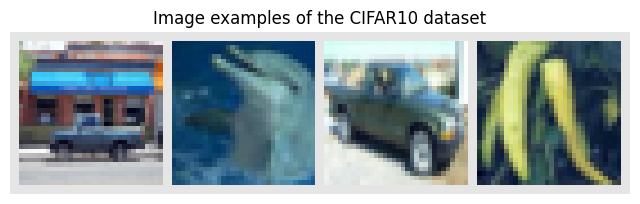

In [6]:
# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# Train ViT

Les valeurs pour le modèle de ViT ont pour l'instant été un peu prises au hasard (à part image_size), ça fait partie des points à améliorer dans la recherche des hyperparamètres.

In [7]:
from vit_pytorch import ViT

model = ViT(image_size = 32, patch_size = 16, num_classes = 10, dim = 256, depth = 2,
            heads = 6, mlp_dim = 1024, dropout = 0.1, emb_dropout = 0.1)
model = model.to(device)
summary(model)

Layer (type:depth-idx)                             Param #
ViT                                                1,536
├─Sequential: 1-1                                  --
│    └─Rearrange: 2-1                              --
│    └─LayerNorm: 2-2                              1,536
│    └─Linear: 2-3                                 196,864
│    └─LayerNorm: 2-4                              512
├─Dropout: 1-2                                     --
├─Transformer: 1-3                                 --
│    └─ModuleList: 2-5                             --
│    │    └─ModuleList: 3-1                        920,064
│    │    └─ModuleList: 3-2                        920,064
├─Identity: 1-4                                    --
├─Sequential: 1-5                                  --
│    └─LayerNorm: 2-6                              512
│    └─Linear: 2-7                                 2,570
Total params: 2,043,658
Trainable params: 2,043,658
Non-trainable params: 0

In [8]:
def train_ViT(model, nb_epochs, gamma, lr):
  # loss function
  criterion = nn.CrossEntropyLoss()
  # optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # scheduler
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

  for epoch in range(nb_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    progress_bar = tqdm(total=len(train_loader), position=0, leave=True)


    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

        progress_bar.update()
    progress_bar.close()

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [9]:
#train_ViT(model, nb_epochs = 10, gamma = 0.1, lr = 0.005)

# Train CoAtNet

In [10]:
# define configuration class
class config:
    img_size = (32, 32)
    num_classes = 10
    batch_size = 8
    lr = 5e-3 
    epochs = 5

In [11]:
from coatnet import CoAtNet, coatnet_0
#Penser à importer le fichier coatnet.py directement dans l'onglet fichier de colab

#model = coatnet_3()
num_blocks = [2, 2, 2, 3, 2]            # L
channels = [32, 64, 92, 128, 256]    # D
block_types=['C', 'C', 'T', 'T']         # 'C' for MBConv, 'T' for Transformer
model = CoAtNet(config.img_size, 3, num_blocks, channels, block_types=block_types, num_classes = config.num_classes)
model = model.to(device)

summary(model)

C:\Users\SGoll\Documents\INF8225 - Intelligence artificielle tech. prob. et d'apprentissage\Projet\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Layer (type:depth-idx)                                  Param #
CoAtNet                                                 --
├─Sequential: 1-1                                       --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─GELU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─Conv2d: 3-4                                 9,216
│    │    └─BatchNorm2d: 3-5                            64
│    │    └─GELU: 3-6                                   --
├─Sequential: 1-2                                       --
│    └─MBConv: 2-3                                      --
│    │    └─MaxPool2d: 3-7                              --
│    │    └─Conv2d: 3-8                                 2,048
│    │    └─PreNorm: 3-9                                16,192
│    └─MBConv: 2-4                      

Ici, num_blocks correspond au nombre de fois qu'on va répéter l'opération dans un block. Par exemple, num_block[1] correspond à L1 dans le schéma d'explication p14 de l'article.



In [12]:
def train_coatnet(model, nb_epochs, gamma, lr):
  # loss function
  criterion = nn.CrossEntropyLoss()
  # optimizer
  optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
  # scheduler
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

  for epoch in range(nb_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    #for data, label in tqdm(train_loader):
    for step, batch in enumerate(tqdm(train_loader)):
        data, label = batch
        data = data.to(device)
        label = label.to(device)
        #print(data.size())

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [13]:
#train_coatnet(model, nb_epochs = 10, gamma = 0.1, lr = 0.005)

# Recherche des meilleurs hyperparamètres

Pour le ViT, les hyperparamètres sur lesquels on peut jouer sont : patch_size, dim, depth, heads, mlp_dim, dropout, emb_dropout

Pour le CoAtNet, les hyperparamètres sur lesquels on peut jouer sont :  num_blocks, channels, block_types=block_types,

Pour les deux : nombre d'épochs, lr, batch_size (peut être)

Connexion à WandB + dictionnaire des paramètres

In [14]:
def validate_model(model, val_loader, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    epoch_val_loss = 0
    epoch_val_accuracy = 0
    with torch.no_grad():
        for i, (data, label) in enumerate(val_loader):
            data, label = data.to(device), label.to(device)

            val_output = model(data)
            val_loss = loss_func(val_output, label)

            _, predicted = torch.max(val_output.data, 1)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)


            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(data, predicted, label, val_output.softmax(dim=1))
    return epoch_val_loss, epoch_val_accuracy

def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

def train_model(model: nn.Module, config: dict):

    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset.dataset, val_loader.dataset.dataset

    optimizer = config['optimizer']
    criterion = config["criterion"]
    scheduler = config["scheduler"]

    device = config['device']
    n_steps_per_epoch = math.ceil(len(train_dataset) / config["batch_size"])

    example_ct = 0
    step_ct = 0

    model.to(device)

    print(f'Starting training for {config["epochs"]} epochs, using {device}.')

    for epoch in range(config['epochs']):

        print(f'\nEpoch {epoch+1}')

        epoch_loss = 0
        epoch_accuracy = 0

        progress_bar = tqdm(total=len(train_loader), position=0, leave=True)

        for step, (data, label) in enumerate(train_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            train_loss = criterion(output, label)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()

            example_ct += len(data)
            metrics = {"train/train_loss": train_loss,
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct,
                      "train/accuracy":acc}

            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb
                wandb.log(metrics)
            step_ct += 1

            progress_bar.update()
        progress_bar.close()

        val_loss, accuracy = validate_model(model, val_loader, criterion, log_images=(epoch==(config['epochs']-1)))

        val_metrics = {"val/val_loss": val_loss,
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}\n")




In [36]:
#config definition
config = {
    # General parameters
    'epochs': 900,
    'image_size' : 32,
    'num_classes' : 100,
    'batch_size': 16,
    'lr': 2.5e-4,
    'momentum' : 0.9,
    'beta1' : 0.9,
    'beta2':0.99,
    'gamma_scheduler' : 0.1,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # ViT parameters model :
    'dropout': 0.1,
    'dim': 256,
    'depth': 2,
    'heads': 6,
    'mlp_dim': 1024,
    'emb_dropout': 0.1,

    #CoAtNet parameters :
    'in_channels': 3,
    'num_blocks':  [2, 2, 3, 4, 2],      # L
    'channels': [ 64, 92, 182, 256, 512],  # D
    'block_types': ['C', 'C', 'T', 'T'],         # 'C' for MBConv, 'T' for Transformer

    # Others
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs
}

torch.manual_seed(config['seed'])

config['train_loader'] = train_loader

config['val_loader'] = val_loader

#Définition des modèles
"""
model = ViT(image_size = config['image_size'],
            patch_size = config['batch_size'],
            num_classes = config['num_classes'],
            dim = config['dim'],
            depth = config['depth'],
            heads = config['heads'],
            mlp_dim = config['mlp_dim'],
            dropout = config['dropout'],
            emb_dropout = config['emb_dropout'])

"""
model = CoAtNet(image_size = (config['image_size'], config['image_size']),
                in_channels = config['in_channels'],
                num_blocks = config['num_blocks'],
                channels = config['channels'],
                block_types=config['block_types'],
                num_classes = config['num_classes'])
#"""

#Si le modèle est ViT
config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
    betas=(config['beta1'],config['beta2'])
)
"""
#Si le modèle est CoAtNet

config['optimizer'] = optim.SGD(
  model.parameters(),
  lr=config['lr'],
  momentum=config['momentum']
)
#"""

config["scheduler"] = lr_scheduler.StepLR(
    config['optimizer'],
    step_size=1,
    gamma=config['gamma_scheduler']
)

config['criterion'] = nn.CrossEntropyLoss()

summary(model)

Layer (type:depth-idx)                                  Param #
CoAtNet                                                 --
├─Sequential: 1-1                                       --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2d: 3-1                                 1,728
│    │    └─BatchNorm2d: 3-2                            128
│    │    └─GELU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─Conv2d: 3-4                                 36,864
│    │    └─BatchNorm2d: 3-5                            128
│    │    └─GELU: 3-6                                   --
├─Sequential: 1-2                                       --
│    └─MBConv: 2-3                                      --
│    │    └─MaxPool2d: 3-7                              --
│    │    └─Conv2d: 3-8                                 5,888
│    │    └─PreNorm: 3-9                                51,768
│    └─MBConv: 2-4                 

Logging WandB

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

In [16]:
# Checking GPU and logging to wandb
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wandb login
!wandb online

!nvidia-smi

wandb: Currently logged in as: sebgoll (2231054-2229491). Use `wandb login --relogin` to force relogin


W&B online. Running your script from this directory will now sync to the cloud.
Sun Apr 30 15:58:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P8                8W /  N/A|   1751MiB /  4096MiB |      8%      Default |
|                                         |                      |            

In [37]:
!wandb online  # online / offline to activate or deactivate WandB logging

with wandb.init(
        config=config,
        project='INF8225-Projet',  # Title of your project
        group='Our_CoAtNet_L_100',  # In what group of runs do you want this run to be in?
        save_code=True,
    ):
    train_model(model, config)

Usage: wandb online [OPTIONS]
Try 'wandb online --help' for help.

Error: Got unexpected extra arguments (# online / offline to activate or deactivate WandB logging)


Starting training for 900 epochs, using cuda.

Epoch 1


100%|██████████| 351/351 [00:22<00:00, 15.34it/s]


Train Loss: 3.333, Valid Loss: 3.117165, Accuracy: 0.23


Epoch 2


100%|██████████| 351/351 [00:22<00:00, 15.49it/s]


Train Loss: 2.831, Valid Loss: 2.687036, Accuracy: 0.31


Epoch 3


100%|██████████| 351/351 [00:22<00:00, 15.42it/s]


Train Loss: 2.539, Valid Loss: 2.361688, Accuracy: 0.38


Epoch 4


100%|██████████| 351/351 [00:22<00:00, 15.40it/s]


Train Loss: 2.446, Valid Loss: 2.139534, Accuracy: 0.43


Epoch 5


100%|██████████| 351/351 [00:22<00:00, 15.41it/s]


Train Loss: 2.319, Valid Loss: 1.946608, Accuracy: 0.48


Epoch 6


100%|██████████| 351/351 [00:22<00:00, 15.49it/s]


Train Loss: 1.951, Valid Loss: 1.773258, Accuracy: 0.51


Epoch 7


100%|██████████| 351/351 [00:22<00:00, 15.40it/s]


Train Loss: 1.915, Valid Loss: 1.630418, Accuracy: 0.56


Epoch 8


100%|██████████| 351/351 [00:22<00:00, 15.45it/s]


Train Loss: 1.573, Valid Loss: 1.445612, Accuracy: 0.59


Epoch 9


100%|██████████| 351/351 [00:22<00:00, 15.41it/s]


Train Loss: 1.742, Valid Loss: 1.322030, Accuracy: 0.62


Epoch 10


100%|██████████| 351/351 [00:22<00:00, 15.45it/s]


Train Loss: 1.316, Valid Loss: 1.234053, Accuracy: 0.66


Epoch 11


100%|██████████| 351/351 [00:22<00:00, 15.44it/s]


Train Loss: 1.284, Valid Loss: 1.071889, Accuracy: 0.71


Epoch 12


100%|██████████| 351/351 [00:22<00:00, 15.40it/s]


Train Loss: 1.172, Valid Loss: 0.974196, Accuracy: 0.72


Epoch 13


100%|██████████| 351/351 [00:22<00:00, 15.37it/s]


Train Loss: 1.175, Valid Loss: 0.903644, Accuracy: 0.75


Epoch 14


100%|██████████| 351/351 [00:22<00:00, 15.42it/s]


Train Loss: 0.963, Valid Loss: 0.833256, Accuracy: 0.77


Epoch 15


100%|██████████| 351/351 [00:22<00:00, 15.45it/s]


Train Loss: 0.805, Valid Loss: 0.702174, Accuracy: 0.80


Epoch 16


100%|██████████| 351/351 [00:22<00:00, 15.60it/s]


Train Loss: 0.767, Valid Loss: 0.645841, Accuracy: 0.82


Epoch 17


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.817, Valid Loss: 0.637495, Accuracy: 0.82


Epoch 18


100%|██████████| 351/351 [00:22<00:00, 15.51it/s]


Train Loss: 0.656, Valid Loss: 0.578058, Accuracy: 0.84


Epoch 19


100%|██████████| 351/351 [00:22<00:00, 15.59it/s]


Train Loss: 0.416, Valid Loss: 0.487997, Accuracy: 0.87


Epoch 20


100%|██████████| 351/351 [00:22<00:00, 15.40it/s]


Train Loss: 0.657, Valid Loss: 0.478665, Accuracy: 0.87


Epoch 21


100%|██████████| 351/351 [00:22<00:00, 15.46it/s]


Train Loss: 0.595, Valid Loss: 0.474609, Accuracy: 0.87


Epoch 22


100%|██████████| 351/351 [00:22<00:00, 15.37it/s]


Train Loss: 0.303, Valid Loss: 0.443780, Accuracy: 0.89


Epoch 23


100%|██████████| 351/351 [00:22<00:00, 15.39it/s]


Train Loss: 0.695, Valid Loss: 0.419647, Accuracy: 0.89


Epoch 24


100%|██████████| 351/351 [00:22<00:00, 15.40it/s]


Train Loss: 0.405, Valid Loss: 0.406894, Accuracy: 0.90


Epoch 25


100%|██████████| 351/351 [00:22<00:00, 15.42it/s]


Train Loss: 0.604, Valid Loss: 0.394000, Accuracy: 0.90


Epoch 26


100%|██████████| 351/351 [00:22<00:00, 15.33it/s]


Train Loss: 0.457, Valid Loss: 0.427945, Accuracy: 0.89


Epoch 27


100%|██████████| 351/351 [00:22<00:00, 15.45it/s]


Train Loss: 0.311, Valid Loss: 0.384120, Accuracy: 0.91


Epoch 28


100%|██████████| 351/351 [00:22<00:00, 15.44it/s]


Train Loss: 0.211, Valid Loss: 0.406062, Accuracy: 0.91


Epoch 29


100%|██████████| 351/351 [00:22<00:00, 15.39it/s]


Train Loss: 0.317, Valid Loss: 0.376908, Accuracy: 0.91


Epoch 30


100%|██████████| 351/351 [00:22<00:00, 15.44it/s]


Train Loss: 0.266, Valid Loss: 0.371296, Accuracy: 0.92


Epoch 31


100%|██████████| 351/351 [00:22<00:00, 15.38it/s]


Train Loss: 0.369, Valid Loss: 0.387204, Accuracy: 0.90


Epoch 32


100%|██████████| 351/351 [00:22<00:00, 15.50it/s]


Train Loss: 0.213, Valid Loss: 0.390200, Accuracy: 0.92


Epoch 33


100%|██████████| 351/351 [00:22<00:00, 15.48it/s]


Train Loss: 0.284, Valid Loss: 0.375798, Accuracy: 0.91


Epoch 34


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.303, Valid Loss: 0.360423, Accuracy: 0.92


Epoch 35


100%|██████████| 351/351 [00:23<00:00, 15.20it/s]


Train Loss: 0.190, Valid Loss: 0.391759, Accuracy: 0.92


Epoch 36


100%|██████████| 351/351 [00:22<00:00, 15.49it/s]


Train Loss: 0.234, Valid Loss: 0.387340, Accuracy: 0.91


Epoch 37


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.188, Valid Loss: 0.381184, Accuracy: 0.92


Epoch 38


100%|██████████| 351/351 [00:22<00:00, 15.52it/s]


Train Loss: 0.128, Valid Loss: 0.370354, Accuracy: 0.92


Epoch 39


100%|██████████| 351/351 [00:22<00:00, 15.44it/s]


Train Loss: 0.126, Valid Loss: 0.399399, Accuracy: 0.92


Epoch 40


100%|██████████| 351/351 [00:22<00:00, 15.41it/s]


Train Loss: 0.269, Valid Loss: 0.387663, Accuracy: 0.92


Epoch 41


100%|██████████| 351/351 [00:22<00:00, 15.48it/s]


Train Loss: 0.180, Valid Loss: 0.362801, Accuracy: 0.92


Epoch 42


100%|██████████| 351/351 [00:22<00:00, 15.42it/s]


Train Loss: 0.182, Valid Loss: 0.392441, Accuracy: 0.92


Epoch 43


100%|██████████| 351/351 [00:22<00:00, 15.57it/s]


Train Loss: 0.112, Valid Loss: 0.367162, Accuracy: 0.93


Epoch 44


100%|██████████| 351/351 [00:22<00:00, 15.57it/s]


Train Loss: 0.309, Valid Loss: 0.401441, Accuracy: 0.92


Epoch 45


100%|██████████| 351/351 [00:22<00:00, 15.49it/s]


Train Loss: 0.220, Valid Loss: 0.389088, Accuracy: 0.92


Epoch 46


100%|██████████| 351/351 [00:22<00:00, 15.59it/s]


Train Loss: 0.221, Valid Loss: 0.409613, Accuracy: 0.92


Epoch 47


100%|██████████| 351/351 [00:22<00:00, 15.52it/s]


Train Loss: 0.311, Valid Loss: 0.412879, Accuracy: 0.92


Epoch 48


100%|██████████| 351/351 [00:22<00:00, 15.58it/s]


Train Loss: 0.165, Valid Loss: 0.411914, Accuracy: 0.92


Epoch 49


100%|██████████| 351/351 [00:22<00:00, 15.56it/s]


Train Loss: 0.148, Valid Loss: 0.385469, Accuracy: 0.93


Epoch 50


100%|██████████| 351/351 [00:22<00:00, 15.75it/s]


Train Loss: 0.190, Valid Loss: 0.374008, Accuracy: 0.93


Epoch 51


100%|██████████| 351/351 [00:22<00:00, 15.62it/s]


Train Loss: 0.213, Valid Loss: 0.382694, Accuracy: 0.93


Epoch 52


100%|██████████| 351/351 [00:22<00:00, 15.57it/s]


Train Loss: 0.174, Valid Loss: 0.382232, Accuracy: 0.93


Epoch 53


100%|██████████| 351/351 [00:22<00:00, 15.60it/s]


Train Loss: 0.266, Valid Loss: 0.359772, Accuracy: 0.94


Epoch 54


100%|██████████| 351/351 [00:22<00:00, 15.63it/s]


Train Loss: 0.123, Valid Loss: 0.361926, Accuracy: 0.93


Epoch 55


100%|██████████| 351/351 [00:22<00:00, 15.52it/s]


Train Loss: 0.126, Valid Loss: 0.394509, Accuracy: 0.93


Epoch 56


100%|██████████| 351/351 [00:22<00:00, 15.28it/s]


Train Loss: 0.281, Valid Loss: 0.400416, Accuracy: 0.93


Epoch 57


100%|██████████| 351/351 [00:22<00:00, 15.69it/s]


Train Loss: 0.108, Valid Loss: 0.417450, Accuracy: 0.93


Epoch 58


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.096, Valid Loss: 0.398753, Accuracy: 0.93


Epoch 59


100%|██████████| 351/351 [00:22<00:00, 15.43it/s]


Train Loss: 0.140, Valid Loss: 0.376524, Accuracy: 0.93


Epoch 60


100%|██████████| 351/351 [00:22<00:00, 15.50it/s]


Train Loss: 0.112, Valid Loss: 0.390996, Accuracy: 0.93


Epoch 61


100%|██████████| 351/351 [00:22<00:00, 15.56it/s]


Train Loss: 0.179, Valid Loss: 0.393586, Accuracy: 0.94


Epoch 62


100%|██████████| 351/351 [00:22<00:00, 15.64it/s]


Train Loss: 0.202, Valid Loss: 0.418387, Accuracy: 0.93


Epoch 63


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.102, Valid Loss: 0.404044, Accuracy: 0.93


Epoch 64


100%|██████████| 351/351 [00:22<00:00, 15.53it/s]


Train Loss: 0.187, Valid Loss: 0.400479, Accuracy: 0.93


Epoch 65


100%|██████████| 351/351 [00:22<00:00, 15.54it/s]


Train Loss: 0.135, Valid Loss: 0.408363, Accuracy: 0.93


Epoch 66


100%|██████████| 351/351 [00:22<00:00, 15.58it/s]


Train Loss: 0.065, Valid Loss: 0.396784, Accuracy: 0.93


Epoch 67


100%|██████████| 351/351 [00:22<00:00, 15.47it/s]


Train Loss: 0.160, Valid Loss: 0.397389, Accuracy: 0.93


Epoch 68


100%|██████████| 351/351 [00:22<00:00, 15.61it/s]


Train Loss: 0.138, Valid Loss: 0.391917, Accuracy: 0.94


Epoch 69


100%|██████████| 351/351 [00:22<00:00, 15.57it/s]


Train Loss: 0.158, Valid Loss: 0.435675, Accuracy: 0.93


Epoch 70


100%|██████████| 351/351 [00:22<00:00, 15.46it/s]


Train Loss: 0.185, Valid Loss: 0.415235, Accuracy: 0.93


Epoch 71


100%|██████████| 351/351 [00:22<00:00, 15.59it/s]


Train Loss: 0.201, Valid Loss: 0.393127, Accuracy: 0.94


Epoch 72


100%|██████████| 351/351 [00:22<00:00, 15.44it/s]


Train Loss: 0.080, Valid Loss: 0.430130, Accuracy: 0.93


Epoch 73


100%|██████████| 351/351 [00:22<00:00, 15.45it/s]


Train Loss: 0.102, Valid Loss: 0.414328, Accuracy: 0.93


Epoch 74


100%|██████████| 351/351 [00:23<00:00, 15.02it/s]


Train Loss: 0.046, Valid Loss: 0.421314, Accuracy: 0.93


Epoch 75


100%|██████████| 351/351 [00:24<00:00, 14.21it/s]


Train Loss: 0.044, Valid Loss: 0.417151, Accuracy: 0.93


Epoch 76


 46%|████▋     | 163/351 [00:14<00:09, 19.50it/s]

train/accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇█▇▇▇██▇██████████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/example_ct,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/train_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▂▃▄▅▅▆▆▇▇▇▇████████████████████████████
val/val_loss,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,0.97656
train/epoch,75.05216
train/example_ct,3390464
train/train_loss,0.05018
val/val_accuracy,0.92891


KeyboardInterrupt: 